In [1]:
!pip install nltk gensim transformers sentence-transformers openai scikit-learn umap-learn matplotlib



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Sample schema
# columns: ["text", "label"] where label ∈ ["Tech", "Finance", "Healthcare", "Sports", "Politics", "Entertainment"]

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk
nltk.download('punkt')

df = pd.read_csv("news_dataset.csv")
df['text'] = df['text'].fillna("")

le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label_enc'], test_size=0.2, random_state=42)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df.head(5)

,text,label,label_enc
0,Healthcare providers are rapidly adopting tele...,Healthcare,2
1,Researchers at MIT have developed quantum proc...,Tech,5
2,The FDA approved a novel vaccine for respirato...,Healthcare,2
3,A bipartisan bill aims to reform immigration p...,Politics,3
4,The national football team secured a dramatic ...,Sports,4


In [4]:
from gensim.models import KeyedVectors

model_path = r"word2vec-google-news-300\word2vec-google-news-300.model"
word2vec = KeyedVectors.load(model_path)


In [5]:
word2vec

In [9]:
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
import numpy as np

def get_word2vec_embedding(text):
    tokens = word_tokenize(text.lower())
    vectors = [word2vec[word] for word in tokens if word in word2vec]
    return np.mean(vectors, axis=0) if vectors else np.zeros(word2vec.vector_size)

w2v_train = np.vstack([get_word2vec_embedding(text) for text in X_train])
w2v_test = np.vstack([get_word2vec_embedding(text) for text in X_test])



In [13]:
w2v_train[0].shape

(300,)

In [14]:
from transformers import BertTokenizer, BertModel
import torch

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_cls_embedding(text):
    tokens = bert_tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        output = bert_model(**tokens)
    return output.last_hidden_state[:, 0, :].squeeze().numpy()

bert_train = np.vstack([get_bert_cls_embedding(text) for text in X_train])
bert_test = np.vstack([get_bert_cls_embedding(text) for text in X_test])


In [15]:
bert_train[0].shape

(768,)

In [16]:
from sentence_transformers import SentenceTransformer

sbert = SentenceTransformer("all-MiniLM-L6-v2")
sbert_train = sbert.encode(X_train.tolist(), show_progress_bar=True)
sbert_test = sbert.encode(X_test.tolist(), show_progress_bar=True)


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [17]:
sbert_train[0].shape

(384,)

In [ ]:
import openai
import time
from dotenv import load_dotenv
load_dotenv()
openai.api_key = os.getenv('OPENAI_API_KEY')

def get_openai_embedding(text):
    try:
        response = openai.Embedding.create(model="text-embedding-ada-002", input=text)
        return response['data'][0]['embedding']
    except Exception as e:
        print("Error:", e)
        return [0.0] * 1536

openai_train = np.vstack([get_openai_embedding(text) for text in X_train])
openai_test = np.vstack([get_openai_embedding(text) for text in X_test])


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

def train_and_report(X_train, X_test, y_train, y_test, label, classes):
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    print(f"\n📊 Classification Report - {label}")
    print(classification_report(y_test, preds, target_names=classes))
    return clf


In [19]:
clf_w2v = train_and_report(w2v_train, w2v_test, y_train, y_test, "Word2Vec", le.classes_)
clf_bert = train_and_report(bert_train, bert_test, y_train, y_test, "BERT", le.classes_)
clf_sbert = train_and_report(sbert_train, sbert_test, y_train, y_test, "SBERT", le.classes_)
#clf_openai = train_and_report(openai_train, openai_test, y_train, y_test, "OpenAI", le.classes_)



📊 Classification Report - Word2Vec
               precision    recall  f1-score   support

Entertainment       1.00      1.00      1.00        34
      Finance       1.00      1.00      1.00        34
   Healthcare       1.00      1.00      1.00        36
     Politics       1.00      1.00      1.00        35
       Sports       1.00      1.00      1.00        30
         Tech       1.00      1.00      1.00        31

     accuracy                           1.00       200
    macro avg       1.00      1.00      1.00       200
 weighted avg       1.00      1.00      1.00       200


📊 Classification Report - BERT
               precision    recall  f1-score   support

Entertainment       1.00      1.00      1.00        34
      Finance       1.00      1.00      1.00        34
   Healthcare       1.00      1.00      1.00        36
     Politics       1.00      1.00      1.00        35
       Sports       1.00      1.00      1.00        30
         Tech       1.00      1.00      1.00    

In [20]:
def classify_article(text):
    emb_w2v = get_word2vec_embedding(text)
    emb_bert = get_bert_cls_embedding(text)
    emb_sbert = sbert.encode([text])[0]
    # emb_openai = get_openai_embedding(text)

    pred_w2v = clf_w2v.predict_proba([emb_w2v])[0]
    pred_bert = clf_bert.predict_proba([emb_bert])[0]
    pred_sbert = clf_sbert.predict_proba([emb_sbert])[0]
    # pred_openai = clf_openai.predict_proba([emb_openai])[0]

    return {
        "Word2Vec": dict(zip(le.classes_, pred_w2v)),
        "BERT": dict(zip(le.classes_, pred_bert)),
        "SBERT": dict(zip(le.classes_, pred_sbert)),
        # "OpenAI": dict(zip(le.classes_, pred_openai)),
    }


C:\Users\harsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


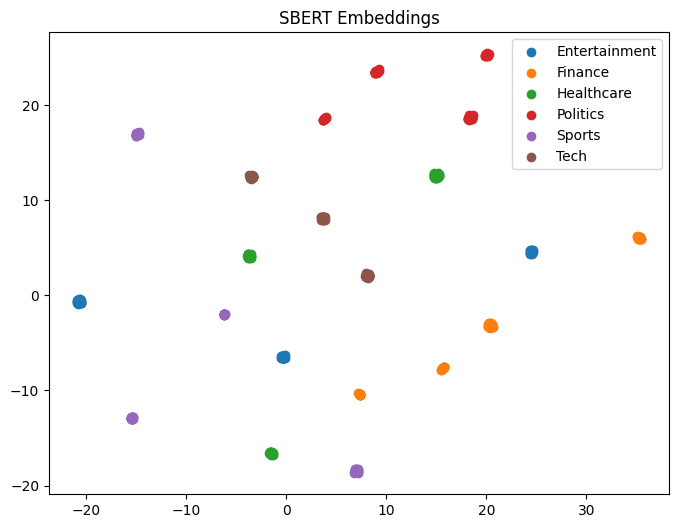

In [21]:
import umap
import matplotlib.pyplot as plt

def visualize(X, y, title):
    reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=42)
    X_umap = reducer.fit_transform(X)
    plt.figure(figsize=(8, 6))
    for label in np.unique(y):
        idx = y == label
        plt.scatter(X_umap[idx, 0], X_umap[idx, 1], label=le.inverse_transform([label])[0])
    plt.legend()
    plt.title(title)
    plt.show()

visualize(sbert_train, y_train.to_numpy(), "SBERT Embeddings")
